# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
!pip install phik -q

In [2]:
!pip install -U scikit-learn -q

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import phik
import math
import shap
from phik import resources, report
from phik.report import plot_correlation_matrix
from scipy import stats as st
from scipy.stats import randint
from math import sqrt
from math import factorial
from matplotlib import pyplot as plt
from scipy.stats import binom, norm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import (
    confusion_matrix, 
    precision_score, 
    recall_score, 
    accuracy_score, 
    r2_score, 
    mean_squared_error, 
    mean_absolute_error,
    roc_auc_score,
    make_scorer,
    f1_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

In [4]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv', sep = ',')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep = ',')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep = ',')

In [5]:
def inf(df, r):
    df1=df.head(r)
    df2=df.info()
    return display(df1, df2)

In [6]:
inf(geo_data_0, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


None

In [7]:
inf(geo_data_1, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


None

In [8]:
inf(geo_data_2, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


None

**Данные загружены, соответствуют описанию. Пропусков не обнаружено, типы данных соответствуют значениям признаков. Переходим к предобработке данных.**

**Проверим данные на наличие дубликатов.**

In [9]:
geo_data_0.duplicated().sum()

0

In [10]:
geo_data_1.duplicated().sum()

0

In [11]:
geo_data_2.duplicated().sum()

0

**Проведём исследовательский анализ данных из каждой таблицы. Проведём статистический анализ всех признаков в таблицах, построим графики для каждого признака.**

In [12]:
list(geo_data_0.columns)

['id', 'f0', 'f1', 'f2', 'product']

In [13]:
g1_hist = ['f0', 'f1', 'f2', 'product']
g2_hist = ['Признак f0', 'Признак f1', 'Признак f2', 'Объём запасов в скважине (тыс. баррелей)']
bins_hist = [30, 30, 30, 30]

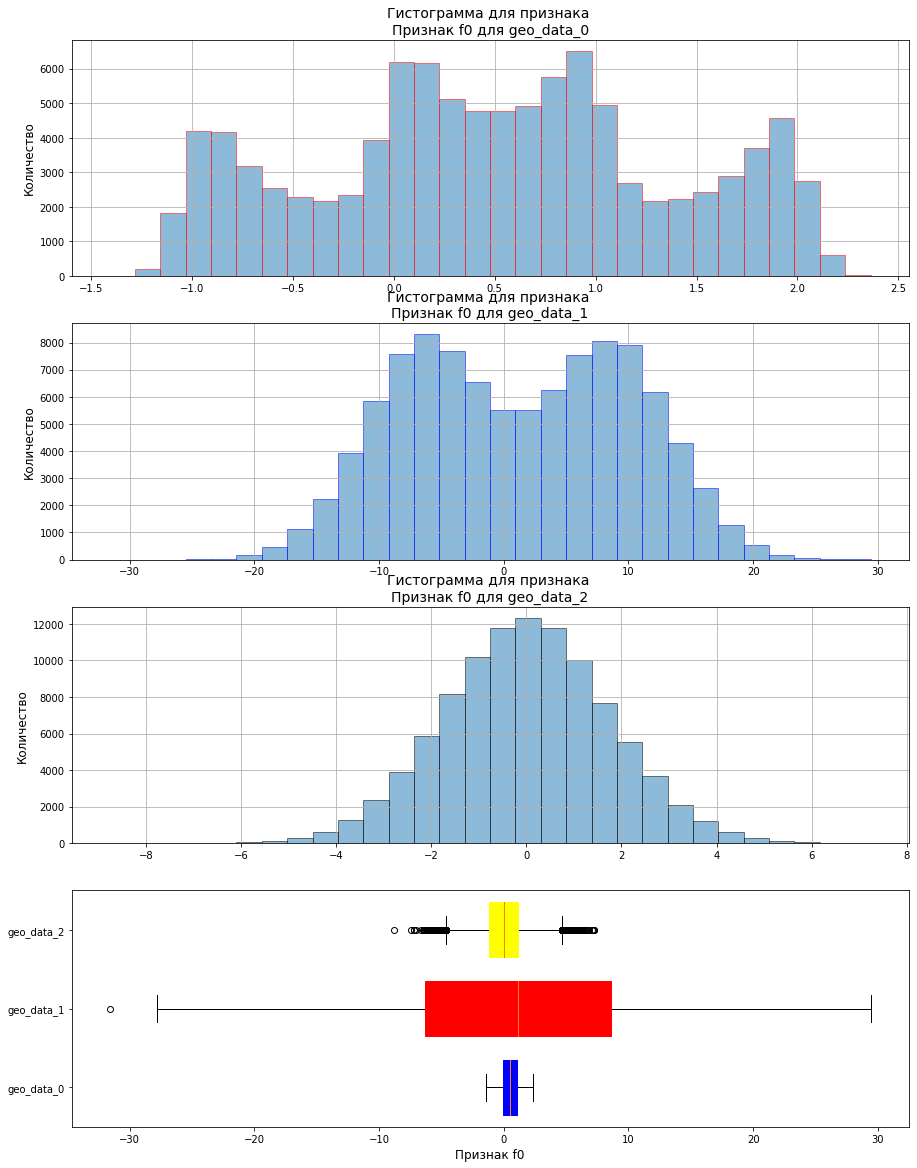

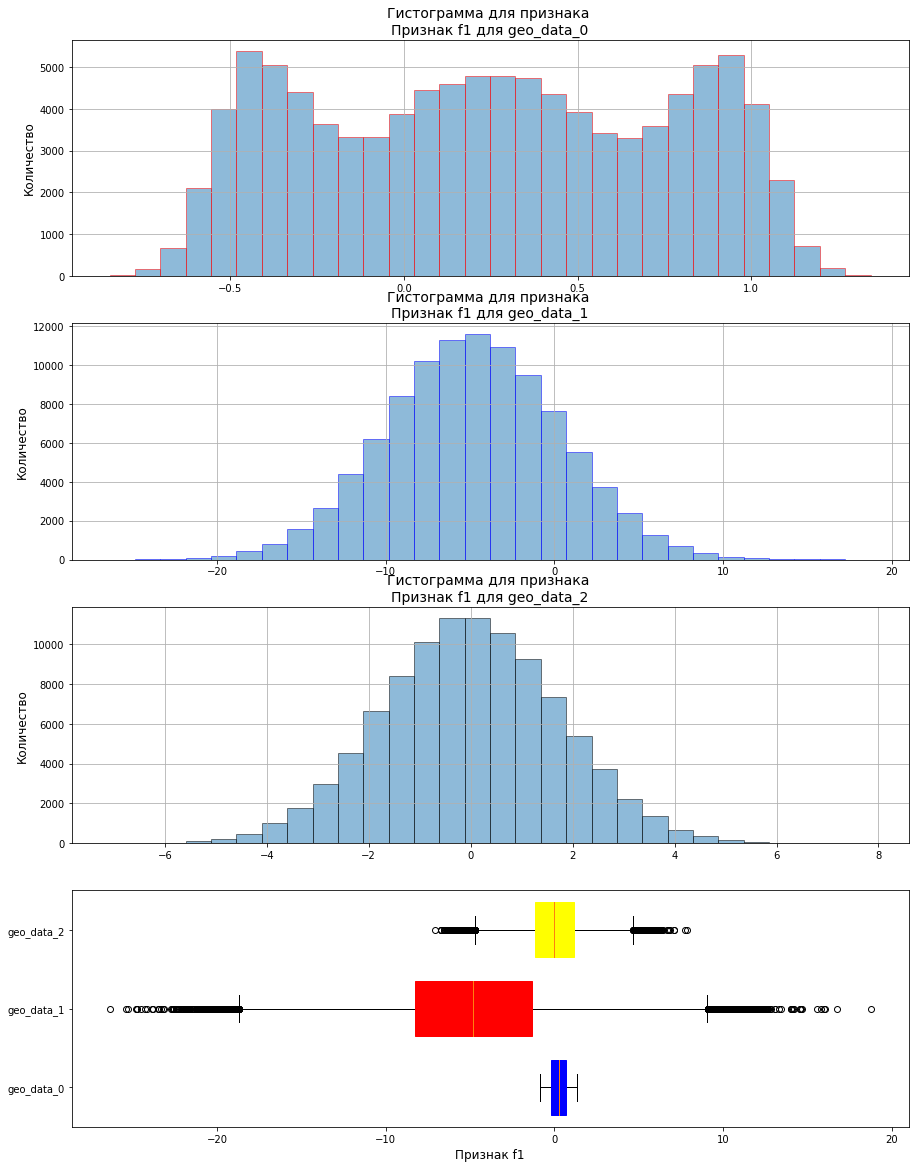

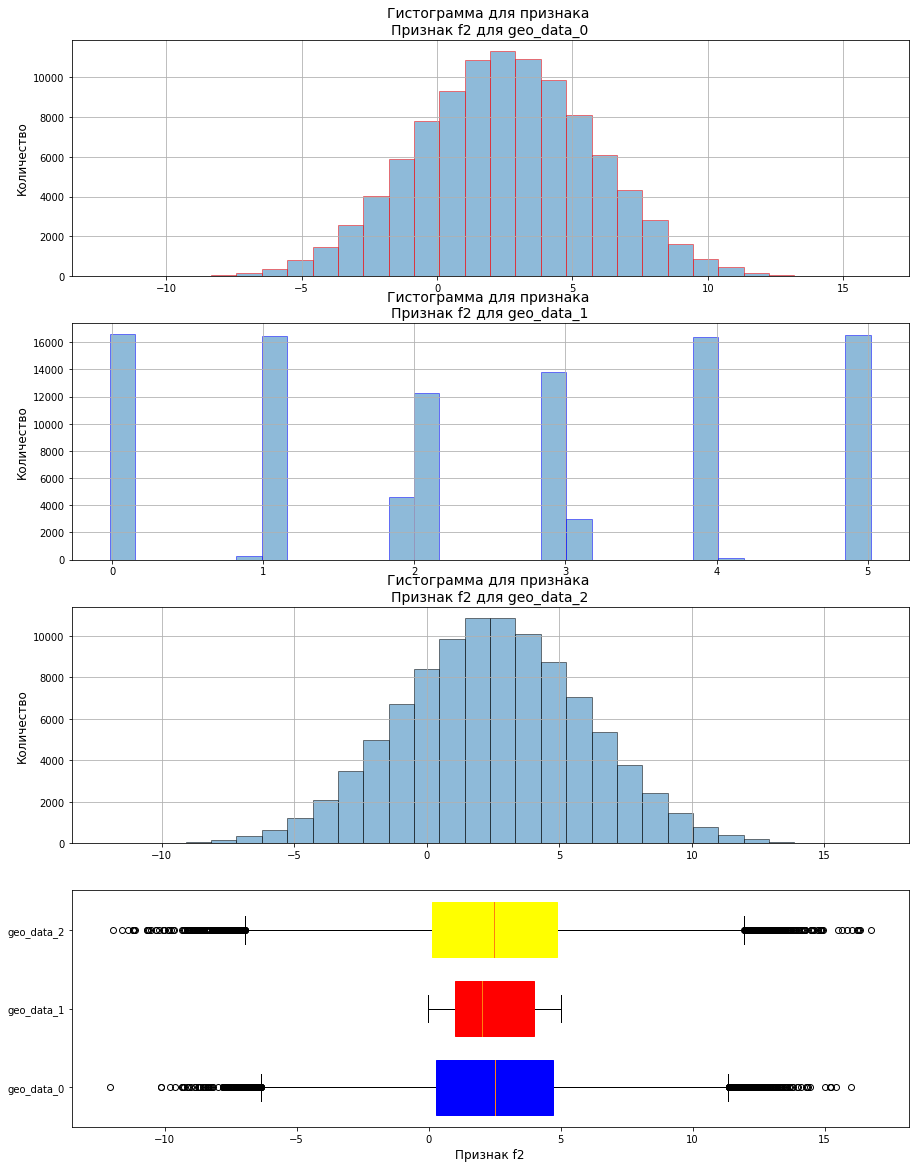

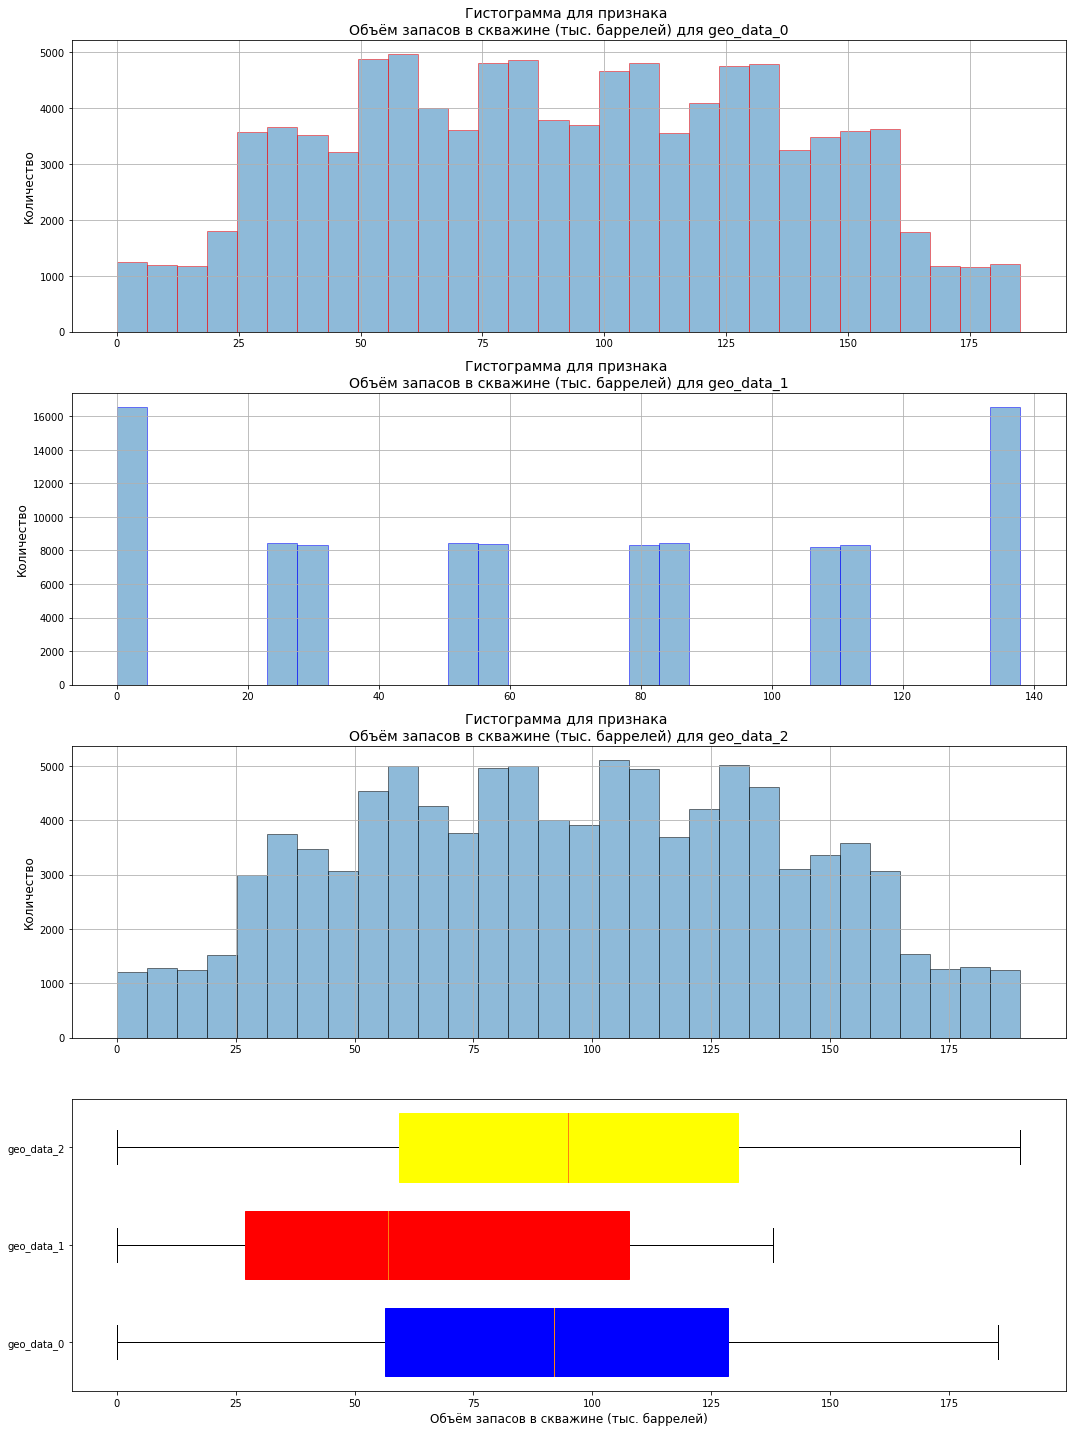

geo_data_0:
count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64
geo_data_1:
count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64
geo_data_2:
count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64
********************************************************************************


In [14]:
for n in range(len(g1_hist)):
    
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,20))
    ax[0].hist(geo_data_0[g1_hist[n]], bins=bins_hist[n], alpha=0.5, edgecolor='red')
    ax[0].set_title(f'Гистограмма для признака \n{g2_hist[n]} для geo_data_0', fontsize=14)
    ax[0].set_ylabel('Количество', fontsize=12)
    ax[0].grid(True)
   
    ax[1].hist(geo_data_1[g1_hist[n]], bins=bins_hist[n], alpha=0.5, edgecolor='blue')
    ax[1].set_title(f'Гистограмма для признака \n{g2_hist[n]} для geo_data_1', fontsize=14)
    ax[1].set_ylabel('Количество', fontsize=12)
    ax[1].grid(True)
    
    ax[2].hist(geo_data_2[g1_hist[n]], bins=bins_hist[n], alpha=0.5, edgecolor='black')
    ax[2].set_title(f'Гистограмма для признака \n{g2_hist[n]} для geo_data_2', fontsize=14)
    ax[2].set_ylabel('Количество', fontsize=12)
    ax[2].grid(True)
    

    ax[3].boxplot(geo_data_0[g1_hist[n]], vert=False, widths=0.7, 
                      positions=[1], patch_artist=True, boxprops=dict(facecolor='blue', color='blue'))
    ax[3].boxplot(geo_data_1[g1_hist[n]], vert=False, widths=0.7,
                      positions=[2], patch_artist=True, boxprops=dict(facecolor='red', color='red'))
    ax[3].boxplot(geo_data_2[g1_hist[n]], vert=False, widths=0.7, 
                      positions=[3], patch_artist=True, boxprops=dict(facecolor='yellow', color='yellow'))
    ax[3].set_xlabel(f'{g2_hist[n]}', fontsize=12)
    ax[3].set_yticks([1, 2, 3])
    ax[3].set_yticklabels(['geo_data_0', 'geo_data_1', 'geo_data_2'])
            
plt.tight_layout()
plt.show()

print('geo_data_0:')
print(geo_data_0[g1_hist[n]].describe(include='all'))
print('geo_data_1:')
print(geo_data_1[g1_hist[n]].describe(include='all'))
print('geo_data_2:')
print(geo_data_2[g1_hist[n]].describe(include='all'))
print(80 * '*')


**По гистограммам и "ящикам с усами" видим следующее… Распределения одних и тех же признаков в разных регионах имеют различия :**
- по признакам f0, f1 и f2 видны различия в диапазонах значений. 
- по признаку f0 для geo_data_2  гистограмма имеет вид нормального распределения, а  для geo_data_0 и  для geo_data_1  распределения имеют мультимодальную форму с 4 пиками для geo_data_0 и 2 пиками для geo_data_1. Все распределения симметричны, однако у geo_data_1 и geo_data_2 значения распределены симметрично 0, у geo_data_0 имеется сдвиг центра распределения в сторону больших значений.
- по признаку f1 для geo_data_0 распределение мультимодальное с тремя пиками, а для geo_data_1 и geo_data_2 имеют вид нормального распределения
- по признаку f2 для geo_data_0 и geo_data_2 распределения имеют нормальный вид, а для geo_data_1 значения сосредоточены около целых значений.
- объём запасов в скважине для geo_data_0 и geo_data_2 имеет довольно равномерное распределение, с несколькими пиками, а для geo_data_1, аналогично признаку f2, значения сосредоточены около определенных значений.

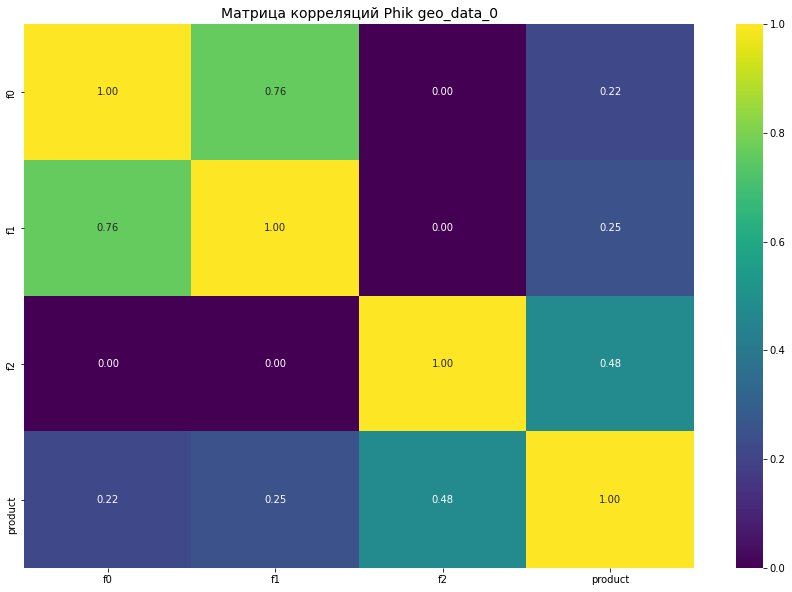

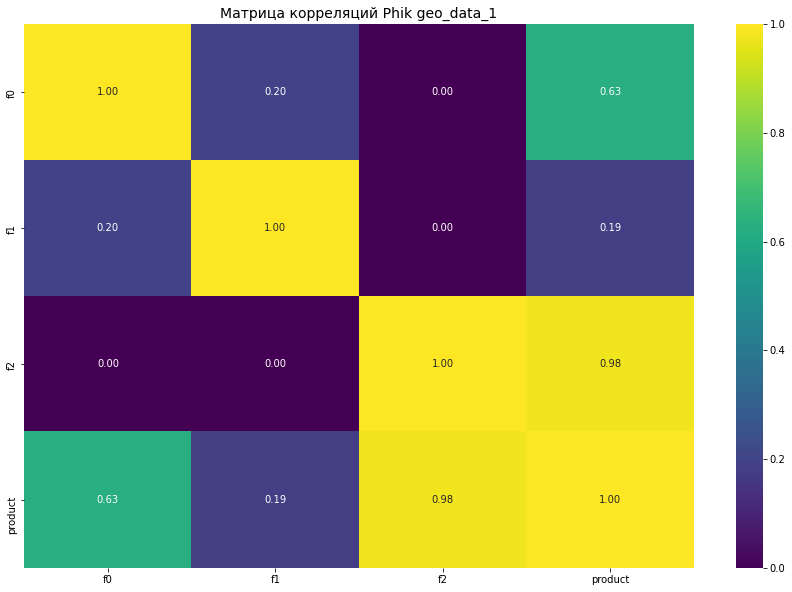

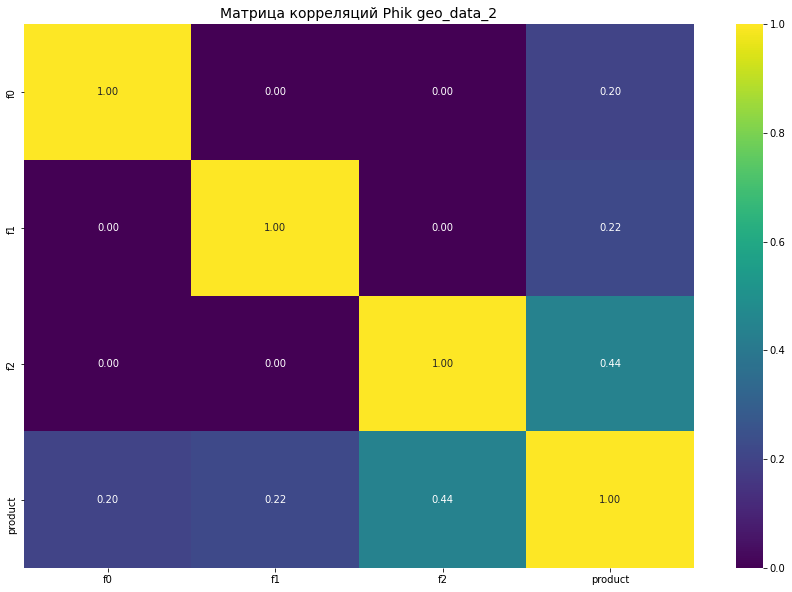

In [15]:
for data, name in [(geo_data_0, 'geo_data_0'), (geo_data_1, 'geo_data_1'), (geo_data_2, 'geo_data_2')]:
    phik_cols = ['f0', 'f1', 'f2', 'product']
    phik_corr_matrix = (data[phik_cols]
                        .phik_matrix(interval_cols=phik_cols)
    )
    plt.figure(figsize=(15, 10))
    sns.heatmap(phik_corr_matrix, cmap='viridis', annot=True, fmt=".2f")
    plt.title(f'Матрица корреляций Phik {name}', fontsize=14)
    plt.show()

**По geo_data_0 и geo_data_2 видим средний уровень корреляции целевого признака с признаком f2 и слабые корреляции с f0 и f1.**

**По geo_data_1 видим очень сильную, близкую к 1, корреляцию целевого признака с признаком f2, довольно сильную корреляцию с f0 и слабую корреляцию с f1.**

**Признаки мультиколлинеарности отсутствуют.**

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены и осмотрены корректно. Радует, что распределения и корреляции были визуализированы!
</div>

## Обучение и проверка модели

**Обучим модель для каждого региона, предсказывающую объём запасов в скважине.**

In [16]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

def geo_models (data):

    X_train, X_test, y_train, y_test = train_test_split(
        data.drop(columns=['product', 'id'], axis=1),
        data['product'],
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model_lr = LinearRegression()
    model_lr.fit(X_train_scaled, y_train)

    y_test_pred = model_lr.predict(X_test_scaled) 
    mse = mean_squared_error(y_test, y_test_pred)

    # Вычислим корень из MSE, чтобы получить RMSE
    rmse = np.sqrt(mse)

    #rmse = mean_squared_error(y_test, y_test_pred, squared = False)
    
    dummy_model = DummyRegressor(strategy='mean')
    dummy_model.fit(X_train_scaled, y_train)
    
    y_dummy_pred = dummy_model.predict(X_test)
    
    mse_dummy = mean_squared_error(y_test, y_dummy_pred)
    rmse_dummy = np.sqrt(mse_dummy)
    
    print(f'Метрика RMSE на тестовой выборке: {rmse:.2f}')
    
    print(f'Метрика RMSE для dummy модели на тестовой выборке: {rmse_dummy:.2f}')
    
    return X_test, y_test_pred, y_test

In [17]:
X_test, y_test_pred, y_test = geo_models(geo_data_0)

Метрика RMSE на тестовой выборке: 37.76
Метрика RMSE для dummy модели на тестовой выборке: 44.28


**Сохраним предсказания и правильные ответы на валидационной выборке.**

In [18]:
def prod_pr():
    df = X_test
    df['product_pred'] = y_test_pred
    df['product'] = y_test
    return df

In [19]:
df_0 = prod_pr()

In [20]:
df_0.head()

,f0,f1,f2,product_pred,product
75721,0.599283,-0.557623,2.121187,101.901017,122.073350
80184,0.739017,-0.463156,-1.347584,78.217774,48.738540
19864,1.422743,-0.534917,3.718798,115.266901,131.338088
76699,1.580244,-0.238458,2.805149,105.618618,88.327757
92991,0.918974,0.023961,2.598575,97.980185,36.959266


In [21]:
product_pred_mean_0 = df_0['product_pred'].mean()
print(f'Средний запас предсказанного сырья для geo_data_0: {product_pred_mean_0:.2f}')

Средний запас предсказанного сырья для geo_data_0: 92.40


In [22]:
X_test, y_test_pred, y_test = geo_models(geo_data_1)

Метрика RMSE на тестовой выборке: 0.89
Метрика RMSE для dummy модели на тестовой выборке: 45.94


In [23]:
df_1 = prod_pr()

In [24]:
df_1.head()

,f0,f1,f2,product_pred,product
75721,6.078076,0.084568,0.002957,0.844738,0.000000
80184,16.462386,2.712946,1.993030,52.921612,53.906522
19864,7.051898,0.766983,4.990194,135.110385,134.766305
76699,-0.240045,-0.380804,3.999693,109.494863,107.813044
92991,13.350111,-8.558281,0.002010,-0.047292,0.000000


In [25]:
product_pred_mean_1 = df_1['product_pred'].mean()
print(f'Средний запас предсказанного сырья для geo_data_1: {product_pred_mean_1:.2f}')

Средний запас предсказанного сырья для geo_data_1: 68.71


In [26]:
X_test, y_test_pred, y_test = geo_models(geo_data_2)

Метрика RMSE на тестовой выборке: 40.15
Метрика RMSE для dummy модели на тестовой выборке: 44.78


In [27]:
df_2 = prod_pr()

In [28]:
df_2.head()

,f0,f1,f2,product_pred,product
75721,2.111118,-1.679773,3.112240,98.301916,117.441301
80184,0.734759,0.747788,3.670879,101.592461,47.841249
19864,-2.513109,0.844631,-4.922889,52.449099,45.883483
76699,-2.035301,-1.522988,5.072839,109.922127,139.014608
92991,2.744145,1.429952,-1.372661,72.411847,84.004276


In [29]:
product_pred_mean_2 = df_2['product_pred'].mean()
print(f'Средний запас предсказанного сырья для geo_data_2: {product_pred_mean_2:.2f}')

Средний запас предсказанного сырья для geo_data_2: 94.77


**Модели обучены, во всех трёх случаях метрики RMSE имеют достаточно хорошие показатели, сравнение с RMSE для dummy-модели это подтверждает. Для geo_data_1 метрика RMSE имеет самый лучший показатель, равный 0.89, что говорит о том, что модель практически точно предсказывает целевой признак. Связано это скорее всего с очень высоким уровнем корреляции целевого признака с f2.**

**Самый высокий средний запас предсказанного сырья видим у geo_data_2 (94.77 тыс. баррелей).**

## Подготовка к расчёту прибыли

**При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей. Все ключевые значения для расчётов сохраним в отдельных переменных, а затем рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.**

In [30]:
quantity_points = 500
budget = 10**10
choice_points = 200
profit_1 = 450000
threshold_probability = 2.5

**Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.**

In [31]:
volume_mat = budget/(choice_points*profit_1)

In [32]:
print(f'Достаточный объём сырья для безубыточной разработки новой скважины {volume_mat:.3f} тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины 111.111 тыс. баррелей


**У нас же самый высокий средний запас предсказанного сырья составляет 94.77 тыс. баррелей в регионе №2, а в других ещё меньше. При таких условиях довольно высок риск убыточности. Для того, чтобы избежать убытков, построим модели, предсказывающие объём запасов в скважине, чтобы иметь возможность выбирать только подходящие нам по характеристикам скважины для разработки.**

## Расчёт прибыли и рисков 

**Создадим функцию расчета прибыли.**

In [33]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    rev = profit_1 * selected.sum() - budget
    return rev

**Посчитаем риски и прибыль для каждого региона. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков (отрицательная прибыль).**

In [34]:
def risk(target, probabilities, region):
    state = np.random.RandomState(12345)
    values=[]
    for i in range(1000):
        target_subsample = target.sample(n=quantity_points, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
        rev = revenue(target, probs_subsample, choice_points)
        values.append(rev)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = len(values[values<0]) / len(values)
    print(f'Средняя прибыль по региону {region}: {average:.2f} тыс.руб.')
    print(f'95% доверительный интервал от {lower:.2f} до {upper:.2f} тыс.руб.')
    print(f'Риск {risk:.2%}')
    if risk<0.025:
        print('Уровень риска СООТВЕТСТВУЕТ целевому показателю (менее 2.5%)')
    else:
        print('Уровень риска НЕ СООТВЕТСТВУЕТ целевому показателю (менее 2.5%)')
    return 

In [35]:
risk(df_0['product'], df_0['product_pred'], 'geo_data_0')

Средняя прибыль по региону geo_data_0: 406278783.42 тыс.руб.
95% доверительный интервал от -117742136.49 до 911737050.75 тыс.руб.
Риск 6.70%
Уровень риска НЕ СООТВЕТСТВУЕТ целевому показателю (менее 2.5%)


In [36]:
risk(df_1['product'], df_1['product_pred'], 'geo_data_1')

Средняя прибыль по региону geo_data_1: 432624131.81 тыс.руб.
95% доверительный интервал от 16846174.93 до 815972526.29 тыс.руб.
Риск 1.90%
Уровень риска СООТВЕТСТВУЕТ целевому показателю (менее 2.5%)


In [37]:
risk(df_2['product'], df_2['product_pred'], 'geo_data_2')

Средняя прибыль по региону geo_data_2: 377362192.42 тыс.руб.
95% доверительный интервал от -170780417.71 до 901772131.39 тыс.руб.
Риск 7.40%
Уровень риска НЕ СООТВЕТСТВУЕТ целевому показателю (менее 2.5%)


**По результатам видим, что средняя прибыль по региону geo_data_1 составляет 432624131.81 тыс.руб., что выше, чем по другим регионам, а также уровень риска составляет 1.9%, что в несколько раз ниже других регионов и удовлетворяет условиям задания (риск ниже 2.5%)**

**По результатам рассчётов для разработки скважин предлагаю регион geo_data_1. Несмотря на то, что средний запас предсказанного сырья в этом регионе значительно ниже других регионов, результат более предсказуем. Наша модель способна очень точно предсказывать объём запасов в скважине по этому региону, благодаря чему риск убытков минимален.**

## Выводы

**В ходе выполнения проекта было сделано следующее:**
- произведена подготовка данных (произведена проверка на наличие пропусков, на соответствие типов данных, на наличие дубликатов)
- произведен исследовательский анализ данных, в результате которого обнаружили различия в видах распределений по признакам в разных регионах, а также различия во взаимосвязях между целевым признаком и другими признаками.
- были обучены модели для всех трёх регионов, во всех трёх случаях метрики RMSE имеют достаточно хорошие показатели, сравнение с RMSE для dummy-модели это подтверждает. Для geo_data_1 метрика RMSE имеет самый лучший показатель, равный 0.89, что говорит о том, что модель практически точно предсказывает целевой признак. Связано это скорее всего с очень высоким уровнем корреляции целевого признака с f2. Самый высокий средний запас предсказанного сырья получился у geo_data_2 (94.77 тыс. баррелей).
- был рассчитан достаточный объём сырья для безубыточной разработки новой скважины, он составил 111.111 тыс. баррелей, что выше нашего самого высокого среднего запаса предсказанного сырья (94.77 тыс. баррелей в регионе №2), а в других ещё меньше. При таких условиях довольно высок риск убыточности. 
- посчитали риски и прибыль для каждого региона. С применением техники Bootstrap с 1000 выборок мы нашли распределение прибыли, нашли среднюю прибыль, 95%-й доверительный интервал и риск убытков (отрицательная прибыль).

**Результаты:**
- средняя прибыль по региону geo_data_1 составляет 432624131.81 тыс.руб., что выше, чем по другим регионам, 
- уровень риска по региону geo_data_1 составляет 1.9%, что в несколько раз ниже других регионов и удовлетворяет условиям задания (риск ниже 2.5%).

**Рекомендации:**

**По результатам рассчётов для разработки скважин предлагается регион geo_data_1. Несмотря на то, что средний запас предсказанного сырья в этом регионе значительно ниже других регионов, результат более предсказуем. Наша модель способна очень точно предсказывать объём запасов в скважине по этому региону, благодаря чему риск убытков минимален.**


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован